# SDV PoC for diabetes dataset

Using [Diabetes dataset](https://www.kaggle.com/datasets/mathchi/diabetes-data-set) for exploring very simple single table mock data use case.

### Requirements

As a **data engineer**, I should be able to specify what is already public to the data scientist and include only that information to the mock dataset.
Let's specify **public data** for diabetes dataset:
* Pregnancies: integer, mean 3.8, gamma distribution
* Age: integer, between 18 and 100, gamma distribution
* Outcome: boolean (0, 1), 35% true (1)
* Other columns should be dropped.

### SDV features used
SDV single table models:
* [TabularPreset](https://sdv.dev/SDV/user_guides/single_table/tabular_preset.html) with and without constraints
* [GaussianCopula](https://sdv.dev/SDV/user_guides/single_table/gaussian_copula.html) with constraints 
   * GaussianCopula supports specifying e.g. probability distributions

Constraints:
 * Constraints can be used to specify rules that each row in the data should meet
 * Cannot be used to specify distributions
 * [ScalarRange](https://sdv.dev/SDV/user_guides/single_table/handling_constraints.html) constraint used for specifying the age range

Distributions:
* GaussianCopola supports specifying the distributions manually but in most cases the model will be able to find the optimal distribution on its own
* [Gamma distribution](https://sdv.dev/SDV/user_guides/single_table/gaussian_copula.html#exploring-the-probability-distributions) specified for age and pregnancies GaussianCopula

Conditional sampling:
* [Conditional sampling](https://sdv.dev/SDV/user_guides/single_table/tabular_preset.html#conditional-sampling) used to specify the outcome distribution

### SDV features **not** used
* CTGAN, CopulaGAN and TVAE [models](https://sdv.dev/SDV/user_guides/single_table/models.html)
* Relational features (obviously)
* [Field and dtype transformers](https://sdv.dev/SDV/api_reference/metadata/api/sdv.metadata.table.Table.html#sdv-metadata-table-table)
* [Field anonymization](https://sdv.dev/SDV/api_reference/metadata/api/sdv.metadata.table.Table.html#sdv-metadata-table-table) and [categorial types](https://sdv.dev/SDV/developer_guides/sdv/metadata.html#categorical-fields-data-anonymization) for anonymization with faker PII categories


### Diabetes data

In [359]:
import pandas as pd
import matplotlib.pyplot as plt
from sdv.lite import TabularPreset
from sdv.tabular import GaussianCopula
from sdv.metadata import Table
from sdv.sampling.tabular import Condition

In [360]:
df = pd.read_csv("datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


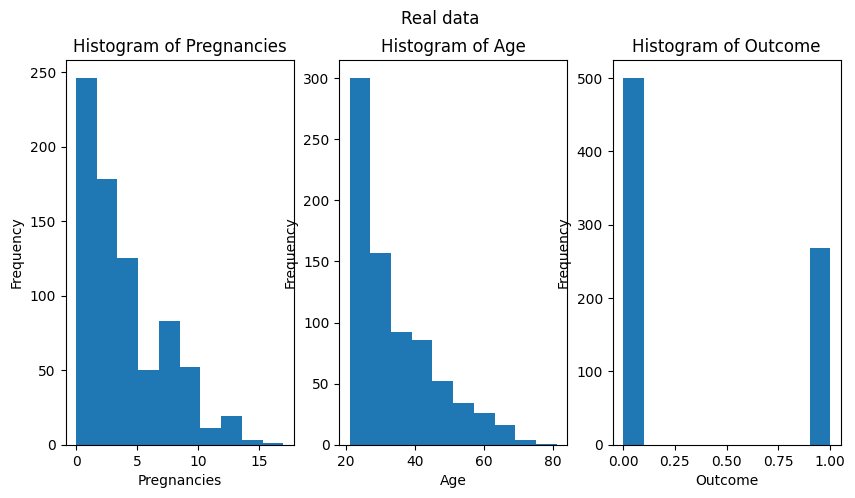

In [361]:
def plot_histograms(df, title):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    df['Pregnancies'].plot(kind='hist', bins=10, ax=axs[0])
    axs[0].set_xlabel('Pregnancies')
    axs[0].set_title('Histogram of Pregnancies')

    df['Age'].plot(kind='hist', bins=10, ax=axs[1])
    axs[1].set_xlabel('Age')
    axs[1].set_title('Histogram of Age')

    df['Outcome'].plot(kind='hist', bins=10, ax=axs[2])
    axs[2].set_xlabel('Outcome')
    axs[2].set_title('Histogram of Outcome')

    plt.suptitle(title)
    plt.show()

plot_histograms(df, "Real data")

In [362]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Specify the table metadata

In [363]:
from sdv.constraints import ScalarRange

metadata_dict = {
    "fields": {
        "Pregnancies": {"type": "numerical", "subtype": "integer"},
        "Age": {"type": "numerical", "subtype": "integer"},
        "Outcome": {"type": "boolean"},
    }
}

metadata_dict_with_constraints = dict(metadata_dict)
age_between_18_100 = ScalarRange(column_name='Age', low_value=18, high_value=100, strict_boundaries=True)
metadata_dict_with_constraints['constraints'] = [age_between_18_100]

table_metadata = Table.from_dict(metadata_dict)
table_metadata_with_constraints = Table.from_dict(metadata_dict_with_constraints)


### Create models

In [364]:
# Use the FAST_ML preset to optimize for modeling time
model = TabularPreset(name="FAST_ML", metadata=table_metadata)
model_with_constraints = TabularPreset(name="FAST_ML", metadata=table_metadata_with_constraints)

# GaussianCopula, specify gamma distributions for age and pregnancies
field_distributions={'Pregnancies': 'gamma', 'Age': 'gamma'}
gc_model = GaussianCopula(table_metadata=table_metadata, field_distributions=field_distributions)
gc_model_with_constraints = GaussianCopula(table_metadata=table_metadata_with_constraints, field_distributions=field_distributions)

In [365]:
model.fit(df)
model_with_constraints.fit(df)

gc_model.fit(df)
gc_model_with_constraints.fit(df)

/Users/antti/.pyenv/versions/3.8.9/envs/mock-data-pocs/lib/python3.8/site-packages/sdv/lite/tabular.py:116: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [366]:
model.save("models/diabetes_fast_ml.pkl")
model.save("models/diabetes_fast_ml_with_constraints.pkl")
model.save("models/diabetes_gaussiancopula.pkl")
model.save("models/diabetes_gaussiancopula_with_constraints.pkl")

### Explore distributions for GaussianCopula model


In [367]:
gc_model.get_distributions()

{'Pregnancies': 'copulas.univariate.gamma.GammaUnivariate',
 'Age': 'copulas.univariate.gamma.GammaUnivariate',
 'Outcome': 'copulas.univariate.truncated_gaussian.TruncatedGaussian'}

In [368]:
gc_model_with_constraints.get_distributions()

{'Pregnancies': 'copulas.univariate.gamma.GammaUnivariate',
 'Outcome': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'Age#18#100': 'copulas.univariate.truncated_gaussian.TruncatedGaussian'}

**NOTE: gamma distribution was ignored for age with range constraint**

### Conditional sampling

Use conditional sampling for specifying the outcome distribution.

In [ ]:
num_rows = 500
outcome_true_probability = 0.35
outcome_true_condition = Condition(column_values={'Outcome': 1}, num_rows=int(outcome_true_probability * num_rows))
outcome_false_condition = Condition(column_values={'Outcome': 0}, num_rows=int((1-outcome_true_probability) * num_rows))

synthetic_data = model.sample_conditions(conditions=[outcome_true_condition, outcome_false_condition])
synthetic_data_with_constraints = model_with_constraints.sample_conditions(conditions=[outcome_true_condition, outcome_false_condition])

synthetic_data_gc_with_constraints = model_with_constraints.sample_conditions(conditions=[outcome_true_condition, outcome_false_condition])

In [370]:
assert synthetic_data.shape[1] == 3
assert synthetic_data.shape[1] == synthetic_data_gc_with_constraints.shape[1]
synthetic_data.head()

,Pregnancies,Age,Outcome
0,7,40,1
1,6,45,1
2,5,31,1
3,2,21,1
4,6,55,1


### Evaluate with SDMetrics

In [371]:
from sdmetrics.reports.single_table import QualityReport

real_data = df[['Pregnancies', 'Age', 'Outcome']]
report = QualityReport().generate(real_data=real_data, synthetic_data=synthetic_data, metadata=table_metadata.to_dict())

Creating report: 100%|██████████| 4/4 [00:00<00:00, 343.35it/s]


Overall Quality Score: 92.68%

Properties:
Column Shapes: 94.09%
Column Pair Trends: 91.28%


In [372]:
report_with_constraints = QualityReport().generate(real_data=real_data, synthetic_data=synthetic_data_with_constraints, metadata=table_metadata_with_constraints.to_dict())

Creating report: 100%|██████████| 4/4 [00:00<00:00, 357.04it/s]


Overall Quality Score: 91.78%

Properties:
Column Shapes: 94.53%
Column Pair Trends: 89.03%


In [373]:
report_gc_with_constraints = QualityReport().generate(real_data=real_data, synthetic_data=synthetic_data_gc_with_constraints, metadata=table_metadata_with_constraints.to_dict())

Creating report: 100%|██████████| 4/4 [00:00<00:00, 367.54it/s]



Overall Quality Score: 91.02%

Properties:
Column Shapes: 93.36%
Column Pair Trends: 88.67%


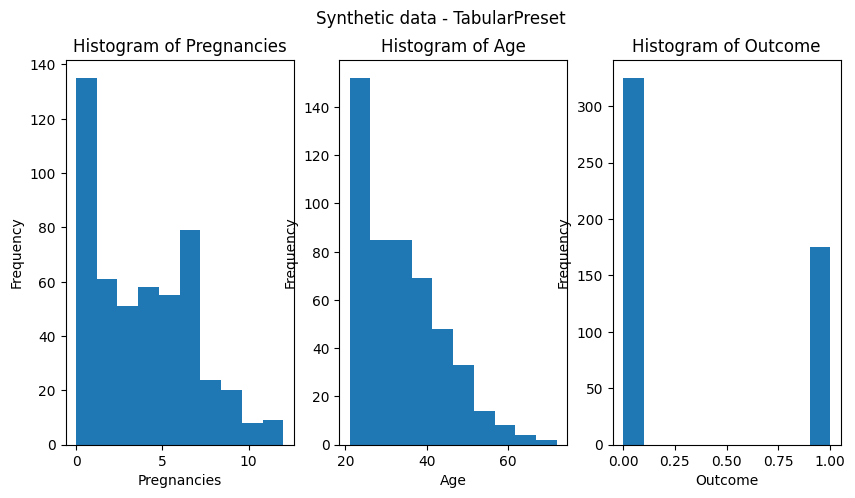

In [374]:
plot_histograms(synthetic_data, "Synthetic data - TabularPreset")

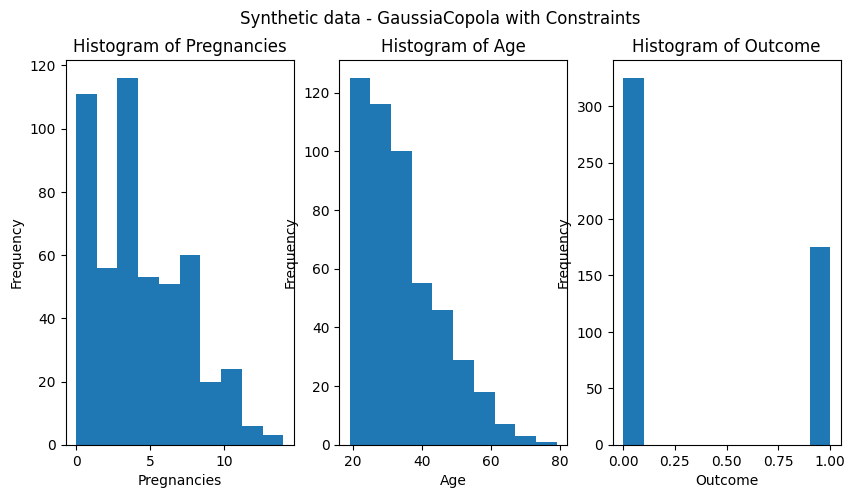

In [375]:
plot_histograms(synthetic_data_gc_with_constraints, "Synthetic data - GaussiaCopola with Constraints")

### Pregnancies mean

In [376]:
print(f"""TabularPreset: {synthetic_data['Pregnancies'].mean()}
TabularPreset with constrains : {synthetic_data_with_constraints['Pregnancies'].mean()}
GaussianCopula with constrains : {synthetic_data_gc_with_constraints['Pregnancies'].mean()}""")

TabularPreset: 3.79
TabularPreset with constrains : 4.16
GaussianCopula with constrains : 4.222


### Conclusions

* At least for this very simple use case, the models captured the requirements well even without manual specification (constraints, distributions etc.)
* Specifying the constraints and distributions had very little impact on the quality scores
* Constraints may slow down the synthetic data model & leak privacy
   * as stated in the [documentation](https://sdv.dev/SDV/user_guides/single_table/handling_constraints.html#faqs), only add the constraint if you require 100% adherence
* Requirements that were **not** met:
   * **mean** of the pregnancies could not be specified directly
      * models still captured the mean well, especially when constraints were not used
